# Change point detaction by knots estimation

In [82]:
import pandas as pd
import numpy as np
import random
from scipy.stats import bernoulli
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import pystan
from pystan import StanModel

In [83]:
def sandwich_kernel(x, x_i):
    """
    x: points required to compute kernel weight
    x_i: reference points location used to compute correspondent distance of each entry points
    return:
        a matrix with N x M such that
        N as the number of entry points
        M as the number of reference points
        matrix entries hold the value of weight of each element
    see also:
      1. https://mc-stan.org/docs/2_24/stan-users-guide/gaussian-process-regression.html
      2. https://en.wikipedia.org/wiki/Local_regression
    """
    N = len(x)
    M = len(x_i)
    k = np.zeros((N, M), dtype=np.double)

    np_idx = np.where(x < x_i[0])
    k[np_idx, 0] = 1

    for m in range(M - 1):
        np_idx = np.where(np.logical_and(x >= x_i[m], x < x_i[m + 1]))
        total_dist = x_i[m + 1] - x_i[m]
        backward_dist = x[np_idx] - x_i[m]
        forward_dist = x_i[m + 1] - x[np_idx]
        k[np_idx, m] = forward_dist / total_dist
        k[np_idx, m + 1] = backward_dist / total_dist

    np_idx = np.where(x >= x_i[M - 1])
    k[np_idx, M - 1] = 1

    # TODO: it is probably not needed
    k = k / np.sum(k, axis=1, keepdims=True)

    return k

In [104]:
T = 365 * 3
N_KNOTS = 36
np.random.seed(2021)

In [105]:
noise = np.random.normal(0, 0.5, T)

In [106]:
is_jump = (np.random.uniform(0, 1, N_KNOTS) > 0.8).astype(np.int32)
is_jump

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [107]:
jump_size = np.random.normal(0, 3, N_KNOTS) 

In [108]:
knots = np.cumsum(is_jump * jump_size)

In [109]:
# normalize time
width = 1/len(knots)
tp = np.arange(1, T + 1)/ T
knots_tp = np.arange(width/2, 1, width)

In [110]:
K = sandwich_kernel(tp, knots_tp)

In [111]:
print(K.shape, knots.shape)

(1095, 36) (36,)


In [112]:
trend = np.matmul(K, knots)
y = trend + noise

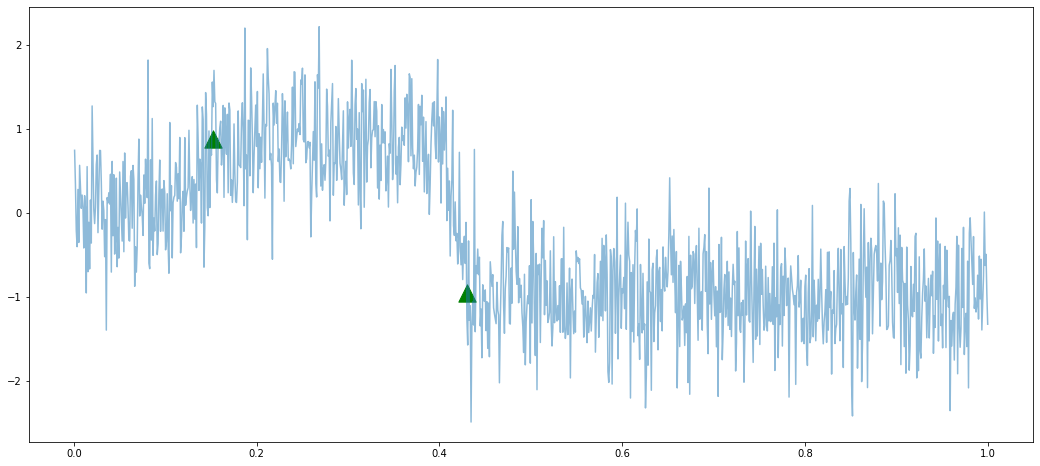

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green');
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='orange');

Question here: can we create a pyro to connect the knots?

In [100]:
cp_stan_code = """
data {
  // response related
  int<lower=1> N_OBS;
  int<lower=1> N_KNOTS_LEV;
  vector[N_OBS] RESPONSE; 
  matrix[N_OBS, N_KNOTS_LEV] K_LEV;
  real<lower=0> SDY;
}
transformed data {
}

parameters {
  vector[N_KNOTS_LEV] lev_knot_drift;
  real<lower=0, upper=SDY> obs_scale;
}
transformed parameters {
  vector[N_OBS] lev;
  vector[N_OBS] yhat;  
  vector[N_KNOTS_LEV] lev_knot;
  lev_knot = cumulative_sum(lev_knot_drift);
  yhat = K_LEV * lev_knot;
}


model {
  lev_knot_drift ~ double_exponential(0, 3);
  obs_scale ~ cauchy(0, SDY)T[0, SDY];
  RESPONSE ~ normal(yhat, obs_scale);
}
"""
sm = pystan.StanModel(model_code=cp_stan_code)
with open('../models/cp_stan.pkl', 'wb') as f:
    pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9816419ef6fe4612b30c516cd68cc7a4 NOW.


In [114]:
input_data = {
    'N_OBS': T,
    'N_KNOTS_LEV': N_KNOTS,
    'RESPONSE': y,
    'K_LEV': K,
    'SDY': np.std(y),
}

In [115]:
fit = sm.optimizing(data=input_data)
yhat = fit['yhat']

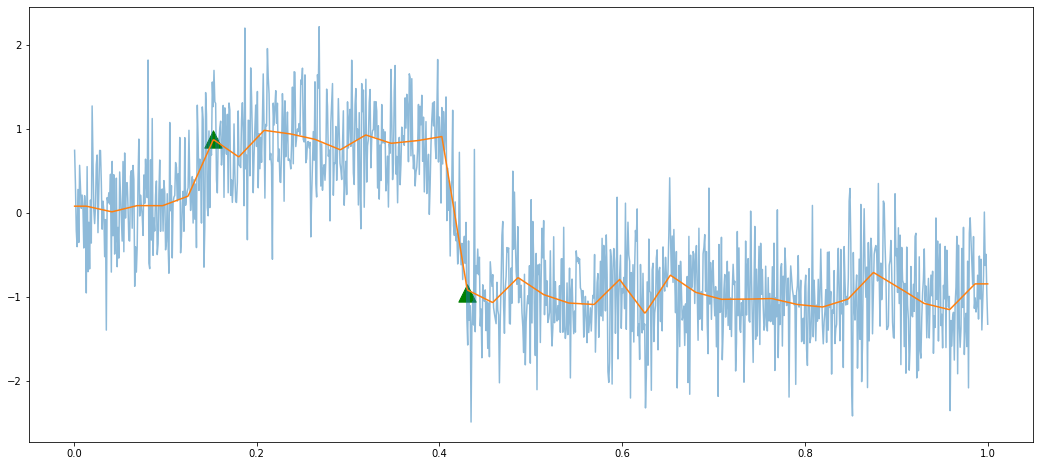

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.plot(tp, y, alpha=0.5)
ax.scatter(knots_tp[is_jump>0], knots[is_jump>0], marker='^', s=300, color='green')
ax.plot(tp, yhat, label='fitted');